In [55]:
#PARAMETER VARIATION USED IN THIS VERSION:

#DENSITY = 3510

#Hr = 1.74E-7

In [56]:
function diffusion(T, kT0, dx, ix, iz, geotherm, T_air) #add Ttop as an argument
  
    Tx = T[:, vec(ix)]
    kx = (kT0[:, ix[1:end-1]] .+ kT0[:, ix[2:end]]) ./ 2 #split thermal diffusivity into x part  


    Tz = T[vec(iz), :]
    kz = (kT0[iz[1:end-1], :] .+ kT0[iz[2:end], :]) ./ 2 #thermal diffusivity in the z direction 
     

    # Apply BC once
    Tz[1,:] .= T_air      # top boundary (constant air temp)
    Tz[end,:] .= Tz[end-1,:]   # bottom Neumann
    
    Tx[:,1] .= Tx[:,2]     # left Neumann
    Tx[:,end] .= Tx[:,end-1]   # right Neumann
    # Tx and Tz are the temperature values at the cell centres in x and z directions respectively
     
    
    qx = - kx .* diff(Tx, dims=2) ./ dx #heat flux in x direction 
    qz = - kz .* diff(Tz, dims=1) ./ dx #heat flux in z direction

    qz[end, :] .= -kz[end, :] .* geotherm[2] #apply boundary condition at the bottom of the model

    dqx = diff(qx, dims=2) ./ dx #change in heat flux in x direction
    dqz = diff(qz, dims=1) ./ dx #change in heat flux in z direction

    dTdt_diffusion = - (dqx .+ dqz) #change in temperature due to diffusion
    #println(size(dTdt_diffusion))
    return dTdt_diffusion
end

diffusion (generic function with 1 method)

In [58]:
function meshgrid(x,y)
    # Create a meshgrid for the given x and y vectors
    X = repeat(x', length(y), 1)  # Repeat x across rows
    Y = repeat(y, 1, length(x))   # Repeat y across columns
    return X, Y
end

meshgrid (generic function with 1 method)

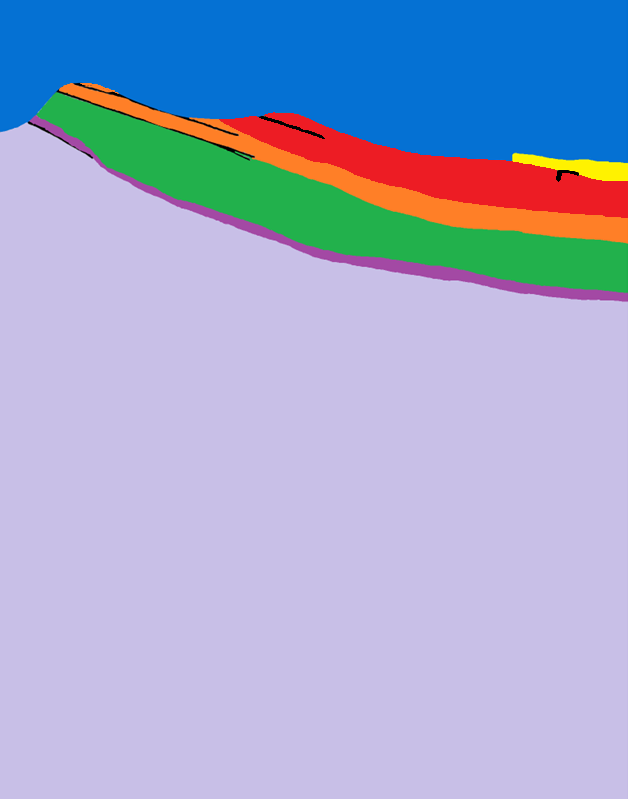

In [59]:
using Images, Plots 
pic_path = "M:/Dissertation Code/UistDomainCroppedFilled.tif" 
domain_image = load(pic_path); #load image from named pic_path 
#display(plot(domain_image, axis=nothing, title="Loaded Domain Image")) 

In [60]:
using Colors
using ImageIO
using TiffImages

function read_image(pic_path, W, Nx)

    ### READ IN THE IMAGE ###
    domain_image = load(pic_path) # load image
    
    p, q = size(domain_image)  # image dimensions (rows, cols)

    # Manual clustering 
    target_grid = zeros(Int, p, q) # array to store unit numbers

   # Define allowed colours (non-black) and their corresponding unit numbers
    target_colors = [
        [5, 113, 211],   # blue - sky
        [255, 242, 0],   # yellow - Uisinis Mylonite
        [237, 28, 36],   # red - upper Corodale Gneiss
        [255, 127, 39],  # orange - mashed/crushed gneiss
        [34, 177, 76],   # green - lower Corodale Gneiss
        [163, 73, 164],  # purple - Pseudotachylite
        [200, 191, 231]  # lilac - Basement Lewisian Gneiss
    ]

    fracture_color = [0, 0, 0]  # black - fractures
    tolerance = 1  # in 0-255 integer RGB space

    # Loop over pixels
    for i in 1:p, j in 1:q
        pixel_rgb = domain_image[i,j]
        pixel_int = round.(Int, 255 .* [red(pixel_rgb), green(pixel_rgb), blue(pixel_rgb)])

        # Check for fractures first: avoid assigning any pixel to black
        if all(abs.(pixel_int .- fracture_color) .<= tolerance)
            target_grid[i,j] = 8  # unit number for fractures
            continue
        end

        # Compute distances to all allowed colors
        dists = [norm(pixel_int .- c) for c in target_colors]
        closest_unit = argmin(dists)  # index of the closest color in target_colors

        target_grid[i,j] = closest_unit  # assign corresponding unit number
    end


    ### DEFINE GRID SIZES ###
    D = W * p / q
    Nz = floor(Int, Nx * p / q)

    ### IMAGE GRID ###
    img_h = W / q
    img_xc = range(img_h/2, stop=W - img_h/2, length=q)
    img_zc = range(img_h/2, stop=D - img_h/2, length=p)
    XCimg, ZCimg = meshgrid(img_xc, img_zc)

    ### MODEL GRID ###
    h = W / Nx
    xc = range(h/2, stop=W - h/2, length=Nx)
    zc = range(h/2, stop=D - h/2, length=Nz)
    XC, ZC = meshgrid(xc, zc)

    ### INTERPOLATE TO MODEL GRID ###
    interp_img_units = zeros(Int, Nz, Nx)
    for i in 1:Nz, j in 1:Nx
        # find closest image pixel in x and z
        closest_x = findmin(abs.(img_xc .- XC[i,j]))[2]
        closest_z = findmin(abs.(img_zc .- ZC[i,j]))[2]
        interp_img_units[i,j] = target_grid[closest_z, closest_x]
    end

    units = Int.(interp_img_units)
    return units, D, Nz, h, zc
end


read_image (generic function with 1 method)

In [61]:
### PARAMETERS ### 

W = 3933 #width of image in metres 
Nx = 200 #specify the number of pixels in the x direction  
pic_path = "M:/Dissertation Code/UistDomainCroppedFilled.tif" #in theory, this could be changed

yr = 365.25 * 24 * 3600 #seconds in a year
tend = 1e6*yr #end time in years
T_air = 11.74 #air temperature in degrees Celsius
println(tend)
#k0 = 1e-6 #diffusion coefficient in m^2/s 

alpha = 0.01
beta = 0.9 
gamma = 0.25
delta = 0.5

3.15576e13


0.5

In [ ]:
using Statistics

units, D, Nz, h, zc = read_image(pic_path, W, Nx)

println("Domain size: ", D, " m, Nz: ", Nz, " h: ", h)

matprop = [
 #   sigma   rho0        Cp        Hr            kp       # Material properties   
 1   1e-6    1           1000      0             0        ;# Sky
 2   2.9     2780.0      875       1.71e-7       1e-21    ;# Yellow: Mylonite 
 3   3       2870        700       5.69e-7       1e-17    ;# Red :Corodale Gneiss 
 4   2.7     2810        700       5.81e-7       1e-15    ;# Orange: Crushged and Altered Corodale Gneiss 
 5   3       2870        700       5.69e-7       1e-17    ;# Green: Corodale Gneiss
 6   1.5     2800        835       3.96e-7       5e-20    ;# Purple: Pseudotachylite  
 7   2.795   3510        835       1.74e-7       1e-18    ;# Lilac: Basement Gneiss 
 8   1e-6    1           1000      0             0        ;# Black: Fracture (water)

]


sigma = matprop[units, 2] #this is the thermal conductivity in W/m/K
rho0 = matprop[units, 3]
Cp = matprop[units, 4]
Hr = matprop[units, 5] 
kp = matprop[units, 6] #permeability in m^2

t_gradient = 35 / 1000
geotherm = [0.0, t_gradient]


CFL = 0.8
nop = 10000


g=9.81

kT0 = sigma ./ rho0 ./Cp  #thermal diffusivity in m^2/s 

mu = 1e-3 #dynamic viscosity in Pa.s
KD = kp ./ mu
@show(maximum(KD), " ",minimum(KD), " ", mean(KD))

aT = 2.5e-5 
rho_fluid = 1000 





Domain size: 5003.928343949045 m, Nz: 254 h: 19.665
maximum(KD) = 1.0e-12
" " = " "
minimum(KD) = 0.0
" " = " "
mean(KD) = 2.4836721692913405e-14


1000

In [63]:
ix = reshape(vcat(1, collect(1:Nx), Nx), 1, :)  #'create a padded vector with a cushion of 1 and Nx on each end 
iz = reshape(vcat(1, collect(1:Nz), Nz), :, 1) #do the same in the z direction  

ix5 = reshape(vcat(1, 1, collect(1:Nx), Nx, Nx), 1, :)
iz5 = reshape(vcat(1, 1, collect(1:Nz), Nz, Nz), :, 1)

cell_width = W / Nx #calculate the cell width in the model 
cell_x_centres = range(cell_width/2, stop=W - cell_width/2; length=Nx) #calculate the x coordinates of the cell centres
cell_z_centres = range(cell_width/2, stop=D - cell_width/2; length=Nz) #calculate the z coordinates of the cell centres 

XC, ZC = meshgrid(cell_x_centres, cell_z_centres) #create a meshgrid of the cell centres for plotting

T = T_air .+ geotherm[2].*ZC  #calculate the temperature at each depth based on the top temperature and the geothermal gradient 
 
Tbottom = T_air + geotherm[2] * D / 1000 #calculate the bottom temperature based on the top temperature and the geothermal gradient
 

#dt = CFL * ((cell_width/2)^2)/maximum(kT0)
dt = CFL * (cell_width^2) / (4 * maximum(kT0))


println(maximum(kT0), " W/m/K") #print the maximum thermal conductivity in the model

println("Time step size: ", dt, " seconds")


1.4932802389248383e-6 W/m/K
Time step size: 5.179365733499999e7 seconds


In [64]:
t = 0 
k = 0 
dTdt = zeros(size(T))

dtau = (h/2)^2 ./ KD 

tolerance = 1e-6 #convergence tolerance for the iterative solver

while t<tend
    t += dt 
    k += 1

    T[units .== 1] .= T_air 
    resnorm = 1.0  # Initialize residual norm for convergence check 

    # Store old temperature and rate
    To = copy(T)
    dTdto = copy(dTdt) 

    while resnorm > tolerance 

        dTdt = diffusion(T, kT0, cell_width, ix, iz, geotherm, T_air) + Hr ./ rho0 ./Cp  #calculate the change in temperature due to diffusion


        res_T = (T-To)/dt - (dTdt + dTdto)/2 
        upd_T = -alpha * res_T * dt 
        T .= T .+ upd_T  #update the temperature 

        resnorm = norm(upd_T[:]) / (norm(T[:]) + eps()) 

    end 

    if k % nop == 0
        avgT = mean(T)
        minT = minimum(T)
        maxT = maximum(T)
        deltaT = maximum(abs.(T .- To))

        println("Step: $k | Sim time: $(round(t/yr, digits=1)) yr | ",
                "Avg T: $(round(avgT, digits=2))°C | ",
                "Min: $(round(minT, digits=2))°C | ",
                "Max: $(round(maxT, digits=2))°C | ",
                "ΔTmax: $(round(deltaT, digits=4))°C | ")
                
    end
end

Step: 10000 | Sim time: 16412.4 yr | Avg T: 93.18°C | Min: 11.74°C | Max: 186.51°C | ΔTmax: 0.1314°C | 
Step: 20000 | Sim time: 32824.8 yr | Avg T: 92.27°C | Min: 11.74°C | Max: 186.51°C | ΔTmax: 0.0736°C | 
Step: 30000 | Sim time: 49237.3 yr | Avg T: 91.74°C | Min: 11.74°C | Max: 186.51°C | ΔTmax: 0.0512°C | 
Step: 40000 | Sim time: 65649.7 yr | Avg T: 91.39°C | Min: 11.74°C | Max: 186.51°C | ΔTmax: 0.0349°C | 
Step: 50000 | Sim time: 82062.1 yr | Avg T: 91.13°C | Min: 11.74°C | Max: 186.51°C | ΔTmax: 0.0268°C | 
Step: 60000 | Sim time: 98474.5 yr | Avg T: 90.94°C | Min: 11.74°C | Max: 186.51°C | ΔTmax: 0.0227°C | 
Step: 70000 | Sim time: 114886.9 yr | Avg T: 90.78°C | Min: 11.74°C | Max: 186.51°C | ΔTmax: 0.0187°C | 
Step: 80000 | Sim time: 131299.4 yr | Avg T: 90.66°C | Min: 11.74°C | Max: 186.51°C | ΔTmax: 0.0149°C | 
Step: 90000 | Sim time: 147711.8 yr | Avg T: 90.57°C | Min: 11.74°C | Max: 186.51°C | ΔTmax: 0.0112°C | 
Step: 100000 | Sim time: 164124.2 yr | Avg T: 90.48°C | Min: 

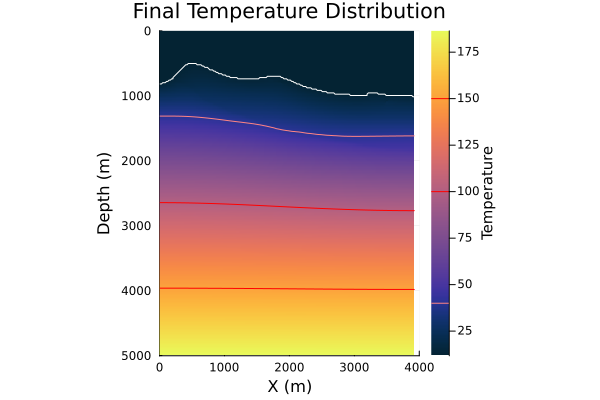

In [65]:
using Plots 
gr() 

# Plot the final temperature distribution
final_temp_plot= plot(cell_x_centres, cell_z_centres,T;
    st = :heatmap, 
    c = :thermal,
    aspect_ratio = 1,
    colorbar = true,
    xlabel = "X (m)",
    xlims = (0, 4000),
    zlims = (0, D),
    ylabel = "Depth (m)",
    colorbar_title = "Temperature",
    title = "Final Temperature Distribution",
    yflip = true,
    clim = (minimum(T), maximum(T))
)

contour!(final_temp_plot, cell_x_centres, cell_z_centres, T, levels = [11.75, 40, 100, 150], linecolor =[:white, :red, :red, :red], label = true, linewidth=[1,3,3,3], colorbar = true) 




In [66]:
savefig(final_temp_plot, "FinalTempsIncRho_20IncHr.pdf")

"m:\\Dissertation Code\\FinalTempsIncRho_20IncHr.pdf"

In [67]:
using CSV, DataFrames

rows = [(x, z, T[j, i]) for (i, x) in enumerate(cell_x_centres),
                             (j, z) in enumerate(cell_z_centres)] |> vec

df = DataFrame(rows, [:x, :z, :Temperature])

CSV.write("FinalTempsIncRho_20IncHr_DATA.csv", df)



"FinalTempsIncRho_20IncHr_DATA.csv"